In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import string
import math
import gensim.downloader as api
import sklearn

In [2]:
print("My vigor is renewed.")

My vigor is renewed.


Retrieve Data.

In [3]:
df = pd.read_excel("Dataset.xlsx")
questionList = df["Question"].unique()
answerList = df["Answer"]
# for answer in answerList:
#     print(answer)
print("Answer list : {}".format(len(answerList)))
print("Question list : {}".format(len(questionList)))

Answer list : 72
Question list : 11


Preprocessing

In [4]:
# Preprocessing

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import inflect

# this function returns a list of tokens, cleaned and preprocessed. 
def preprocess_document(corpus, isLemma=False, isStopwords=False, isInflect=False, isNumberFiltered=True):   
   
   inflector = inflect.engine() # prepare inflector
   stop_words = set(stopwords.words("english"))
   lemmatizer = WordNetLemmatizer()
   punctuations = string.punctuation

   # if numbers are filtered, add that to the punctuation string
   if isNumberFiltered:
      punctuations += "1234567890"

   # case fold
   corpus = corpus.lower()

   # remove puncs
   corpus = "".join([char for char in corpus if char not in punctuations])

   # tokenize it.
   token_list = nltk.word_tokenize(corpus)

   for i in range(len(token_list)):
      # if inflect
      if isInflect:
         if token_list[i].isdigit():
            token_list[i] = inflector.number_to_words(token_list[i])

      # if lemma
      if isLemma:
         tagged_word = nltk.pos_tag([token_list[i]])
         wordnet_pos = get_wordnet_pos(tagged_word[0][1])
         token_list[i] = lemmatizer.lemmatize(tagged_word[0][0], pos=wordnet_pos)
      
      # if stopword
      if isStopwords:
         if token_list[i] in stop_words or token_list[i].isdigit():
            token_list[i] = "#" # mark as #
      
   # remove the marked strings
   token_list = [token for token in token_list if token != "#"]
   return token_list
            
def get_wordnet_pos(tag):
    """Map POS tag to WordNet POS tag"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN # solves as noun by default.



Get Word Set (for TF-IDF)

In [5]:
# get all words
import contractions
word_list = ""
for i in range(len(df)):
    word_list += " {}".format(df["Answer"][i])

word_list = word_list.lower()

word_list = contractions.fix(word_list)
    
# remove punctuations
corpus = "".join([char for char in word_list if char not in string.punctuation])

word_set = set()
for word in nltk.word_tokenize(corpus):
    word_set.add(corpus)
word_tokens = preprocess_document(word_list, isLemma=True)
word_set = set(word_tokens)
print(len(word_set))
for word in word_set:
    print(word)

504
relationship
while
abuse
cost
mammal
under
more
mistake
call
well
born
suffer
adult
fetus
animal
god
most
kbbi
mortal
leave
trivial
transgression
than
he
sense
difficulty
feel
outlet
harder
peter
good
heaven
aware
individual
output
no
innately
these
glorify
matter
suppose
die
financially
assault
still
deal
beg
be
general
obvious
go
really
objective
life
ability
support
prolife
all
yet
not
get
to
relational
actually
meaning
yes
justice
fight
automatically
world
texas
effect
personally
aka
hell
conflict
many
response
teenager
it
know
whether
eternal
eye
abortion
have
free
up
i
praise
would
necessarily
hot
optimal
creation
two
like
medical
think
advanced
my
same
subject
surely
valuable
purpose
decision
incest
possess
human
imperfectly
religion
one
her
when
capable
ape
option
family
answer
regret
by
eternally
difficult
usual
and
choice
very
concept
long
wicked
understands
event
creature
involve
indo
continuously
month
outside
middle
picture
grace
chimpanzee
belief
worship
return
such
t

It is that simple.

Function for TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
# takes a bunch of documents and make a TF-IDF out of them. Returns a tf-idf matrix and a df as well.
def get_tfidf(documents):
    documents = [preprocess_document(doc, isLemma=True, isStopwords=True) for doc in documents]
    flattened_documents = [' '.join(doc) for doc in documents]
    vectorizer = TfidfVectorizer()
    matrix = vectorizer.fit_transform(flattened_documents)

    tfidf_keys  = vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(matrix.toarray(), columns=tfidf_keys)

    return df_tfidf, matrix

Get TF-IDF matrix

In [17]:
my_tfidf, my_matrix = get_tfidf(df["Answer"])

for i in range(len(my_tfidf.loc[0])):
    if my_tfidf.loc[0][i] != 0:
        print(i, " | ", my_tfidf.loc[0][i])



27  |  0.3018470105161982
43  |  0.5622631336980173
73  |  0.28113156684900864
93  |  0.2519347888418095
94  |  0.2519347888418095
125  |  0.33104378852339733
137  |  0.33104378852339733
238  |  0.24083468900936067
305  |  0.33104378852339733


Draw this shit lmao

In [18]:
import seaborn as sns

plt.figure(figsize=(100,100))
sns.heatmap(my_tfidf, annot=True, cmap='Blues')
plt.show()


Word and sentence embeddings

In [19]:
# load and use the word embedding
import gensim
import gensim.downloader as api
from nltk.test.gensim_fixt import setup_module
setup_module()

model = api.load('word2vec-google-news-300')

In [20]:
# embed the individual words of a document. takes a list of tokens and a w2v model, returns a list of tuples(word, 300d vector).
def word_embed(document, model):
    word_embed_pairs = []
    for word in document:
        if word in model:
            word_embed_pairs.append((word, model[word]))
    return word_embed_pairs


# embed the words into sentences with a preferred method. takes a list of tuples (word, 300d vector), a tfidf matrix, and an index. returns a 300d vector aggregated sentence with the preferred method.
def sentence_embed(word_embed_pair_list, tfidf_matrix, index):
    weighted_wvs = []
    for pair in word_embed_pair_list:
        tfidf_weight = 0
        if pair[0] in tfidf_matrix:
            tfidf_weight = tfidf_matrix[pair[0]][index]
        weighted_wvs.append(pair[1] * tfidf_weight)

    weighted_wvs = np.array(weighted_wvs)
    sentence_vector = np.mean(weighted_wvs, axis=0)
    return sentence_vector
    

   
    

Adding the embedding for each motherfucker.

In [21]:
docs = [preprocess_document(doc, isLemma=True, isStopwords=True) for doc in df["Answer"]]
word_embedded_docs = []
for doc in docs:
    word_embedded_docs.append(word_embed(doc, model))

# sentence_embed("bababui", tfidf_matrix=my_tfidf, index=1)
doc_embeds = []
for i in range(len(word_embedded_docs)): # 72
    doc_embeds.append(sentence_embed(word_embedded_docs[i], my_tfidf, i))

df["Document Embed"] = doc_embeds
df

No                                           Question  \
0    1                          How did we come to exist?   
1    2                          How did we come to exist?   
2    3                    Do you think you need to exist?   
3    4                    Do you think you need to exist?   
4    5                    Do you think you need to exist?   
..  ..                                                ...   
67  68  We see from our side that maybe they are miser...   
68  69  We see from our side that maybe they are miser...   
69  70  We see from our side that maybe they are miser...   
70  71  We see from our side that maybe they are miser...   
71  72  We see from our side that maybe they are miser...   

                                               Answer      Event Speaker  \
0   Everybody should believe that they are creatio... 2022-02-19       P   
1   We came from evolution. This is undeniable, an... 2022-02-19       G   
2   We don't really need to exist. Even if I don't... 2022-02-19       P   
3   I don't think we need to exist. As Peter said,... 2022-02-19      Je   
4          I think we are a part of a bigger picture. 2022-02-19      Th   
..                                                ...        ...     ...   
67  Everyone has rights, even fetuses or babies, b... 2023-07-02      St   
68  Is it wrong to regret life? That is the right ... 2023-07-02       G   
69  Actually, we humans are well aware that life i... 2023-07-02     Yot   
70  The law didn't need to be revised. Choosing th... 2023-07-02      St   
71  Rape victims, let's not confuse them, let's di... 2023-07-02     Yot   

                                       Document Embed  
0   [-0.0048807305, -0.023468189, 0.0058383015, 0....  
1   [0.02037403, 0.0046991236, -0.02176078, 0.0393...  
2   [0.008178462, 0.0058039343, 0.0105169015, 0.03...  
3   [0.0067505464, 0.0055775493, -0.005131879, 0.0...  
4   [0.024215888, 0.059753582, -0.020245055, 0.054...  
..                                                ...  
67  [0.019708443, 0.0017890795, 0.0043854564, 0.02...  
68  [0.016631177, 0.008324474, 0.010115437, 0.0326...  
69  [0.015551925, 0.00063774455, 0.007183914, 0.03...  
70  [0.0090299165, 0.013343265, 0.017874967, 0.036...  
71  [0.005419608, 0.0052445536, 0.004414719, 0.018...  

[72 rows x 6 columns]

Drawing

In [22]:
from sklearn.manifold import TSNE

# returns a tsne shrinkage also...
def plot_documents(df):
    labels = np.array(df["No"])
    values = list(df["Document Embed"]) # don't forget to list it first, then np array it later.

    # train model
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(values))

    # plot
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    # use the thing to find new clusters.
    return new_values


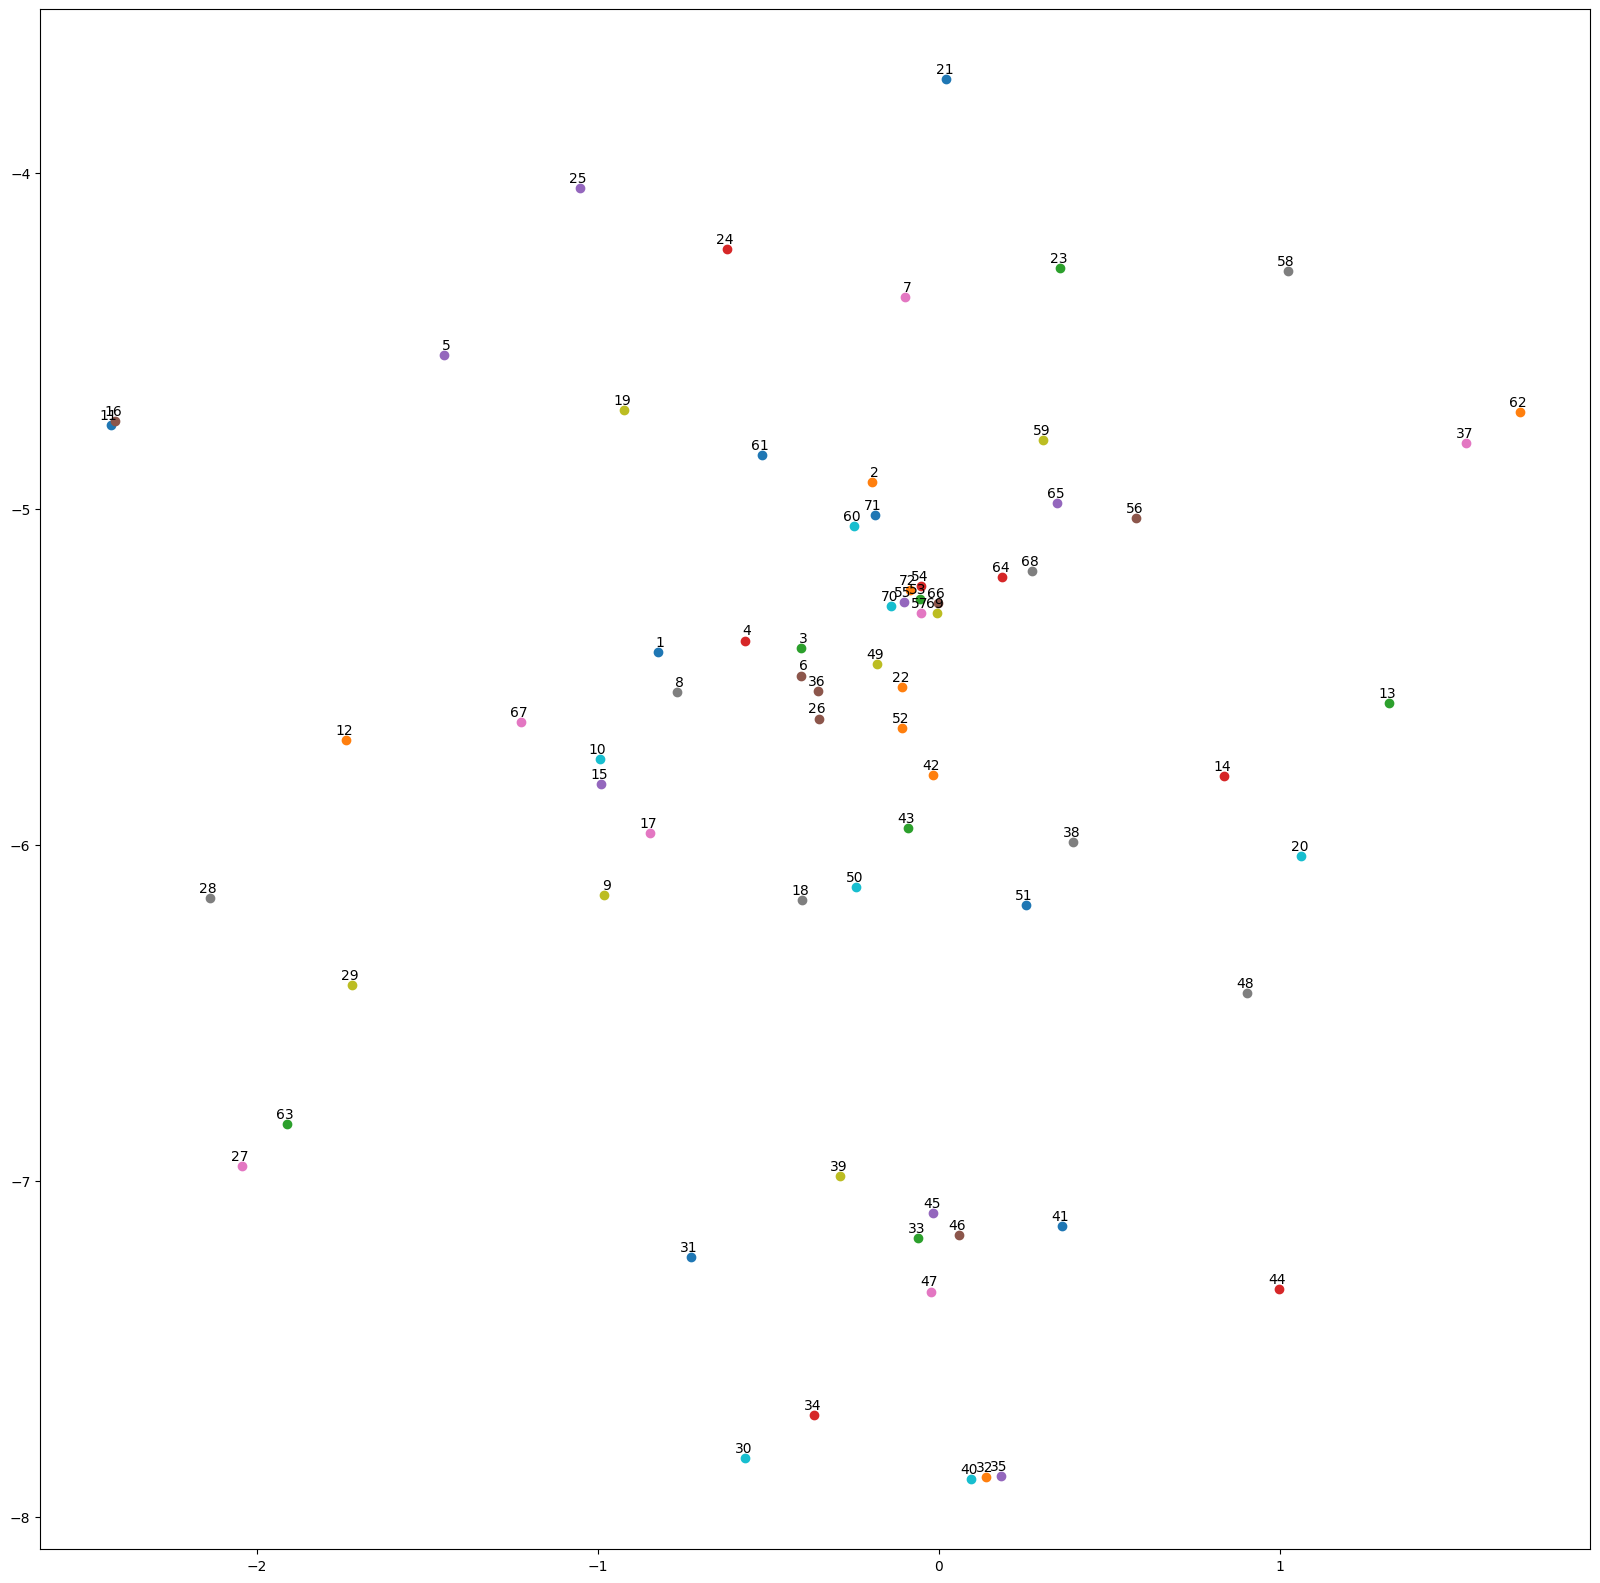

In [24]:
tsne_values = plot_documents(df)

Cluster

In [25]:
from sklearn.cluster import DBSCAN

def dbscan_draw(vectors, epsilon, min):
    dbscan = DBSCAN(eps=epsilon, min_samples=min)
    clusters = dbscan.fit_predict(vectors)
    plt.title("to the depths of depravity {} and the cusp of blasphemy {}.".format(epsilon, min))
    plt.scatter(vectors[:, 0], vectors[:, 1], c=clusters)
    plt.show()
    print(clusters)
    return clusters
    

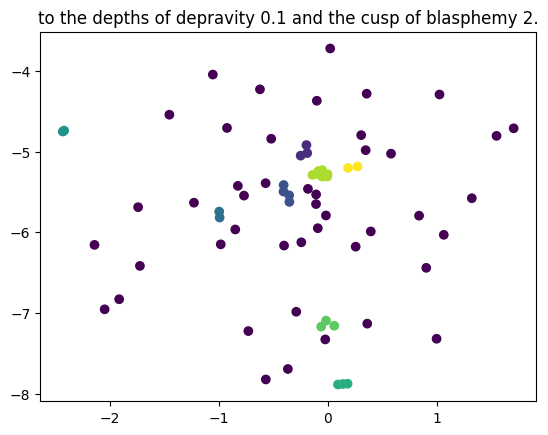

[-1  0  1 -1 -1  1 -1 -1 -1  2  3 -1 -1 -1  2  3 -1 -1 -1 -1 -1 -1 -1 -1
 -1  1 -1 -1 -1 -1 -1  4  5 -1  4  1 -1 -1 -1  4 -1 -1 -1 -1  5  5 -1 -1
 -1 -1 -1 -1  6  6  6 -1  6 -1 -1  0 -1 -1 -1  7 -1  6 -1  7  6  6  0  6]


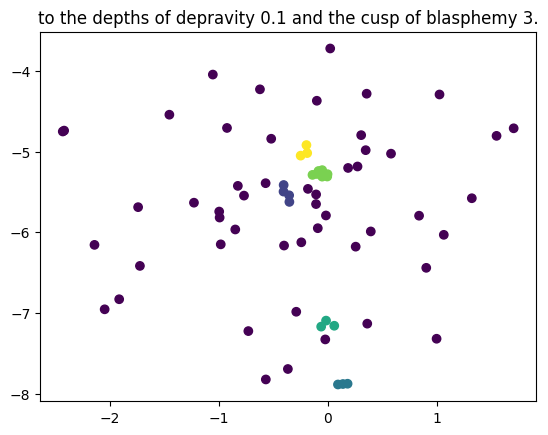

[-1  4  0 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1  1  2 -1  1  0 -1 -1 -1  1 -1 -1 -1 -1  2  2 -1 -1
 -1 -1 -1 -1  3  3  3 -1  3 -1 -1  4 -1 -1 -1 -1 -1  3 -1 -1  3  3  4  3]


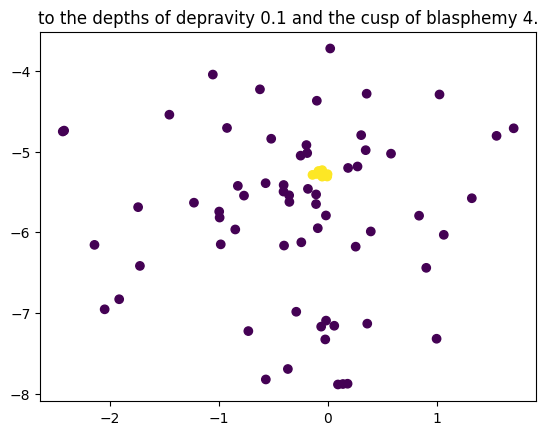

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  0  0  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0  0 -1  0]


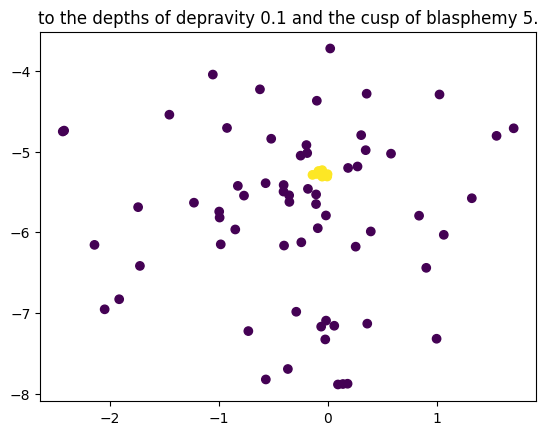

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  0  0  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0  0 -1  0]


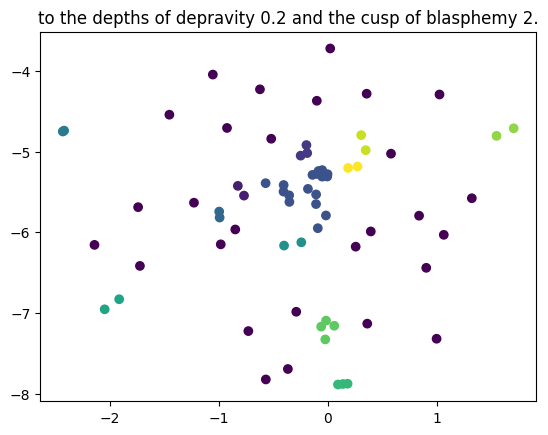

[ 0  1  2  2 -1  2 -1  0 -1  3  4 -1 -1 -1  3  4 -1  5 -1 -1 -1  2 -1 -1
 -1  2  6 -1 -1 -1 -1  7  8 -1  7  2  9 -1 -1  7 -1  2  2 -1  8  8  8 -1
  2  5 -1  2  2  2  2 -1  2 -1 10  1 -1  9  6 11 10  2 -1 11  2  2  1  2]


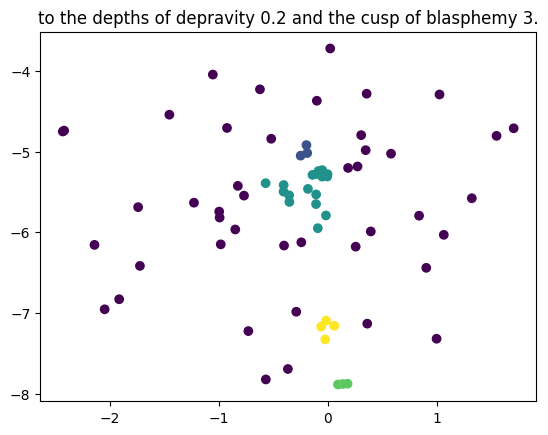

[-1  0  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1  1 -1 -1 -1 -1 -1  2  3 -1  2  1 -1 -1 -1  2 -1  1  1 -1  3  3  3 -1
  1 -1 -1  1  1  1  1 -1  1 -1 -1  0 -1 -1 -1 -1 -1  1 -1 -1  1  1  0  1]


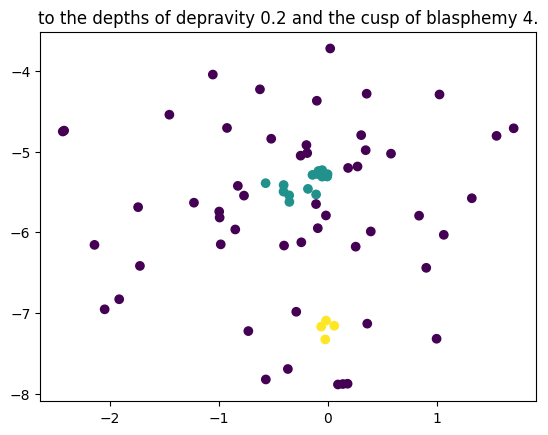

[-1 -1  0  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1
  0 -1 -1 -1  0  0  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0  0 -1  0]


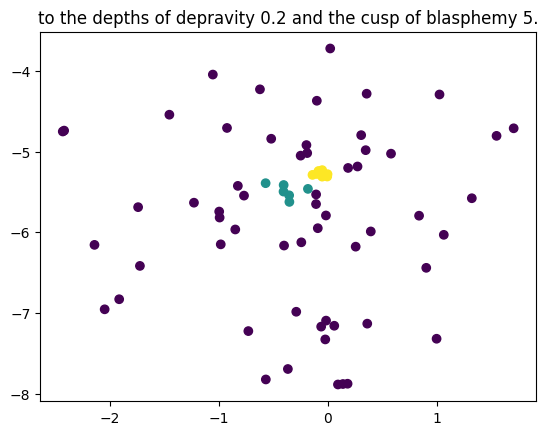

[-1 -1  0  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  0 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1]


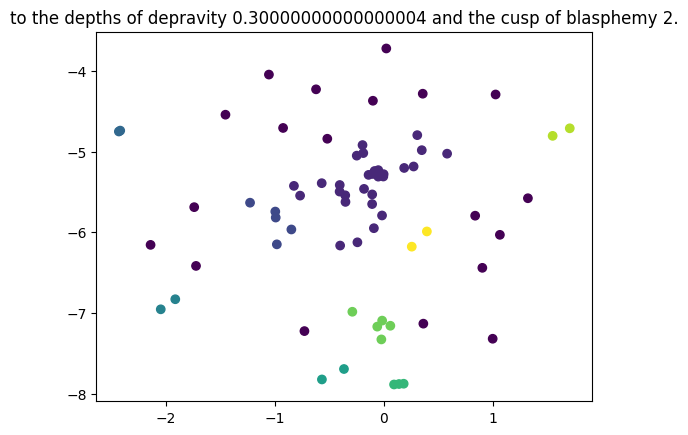

[ 0  0  0  0 -1  0 -1  0  1  1  2 -1 -1 -1  1  2  1  0 -1 -1 -1  0 -1 -1
 -1  0  3 -1 -1  4 -1  5  6  4  5  0  7  8  6  5 -1  0  0 -1  6  6  6 -1
  0  0  8  0  0  0  0  0  0 -1  0  0 -1  7  3  0  0  0  1  0  0  0  0  0]


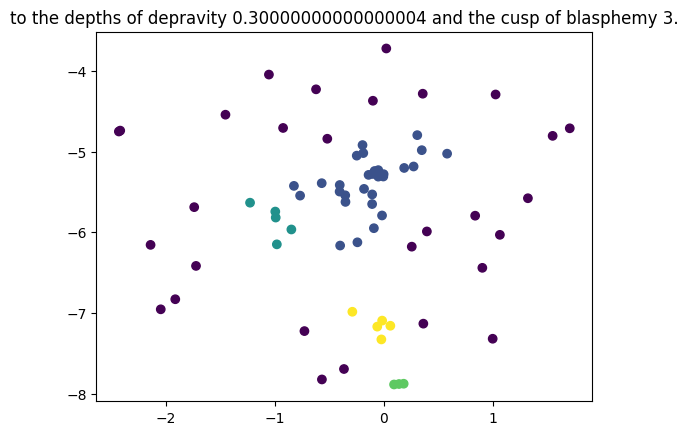

[ 0  0  0  0 -1  0 -1  0  1  1 -1 -1 -1 -1  1 -1  1  0 -1 -1 -1  0 -1 -1
 -1  0 -1 -1 -1 -1 -1  2  3 -1  2  0 -1 -1  3  2 -1  0  0 -1  3  3  3 -1
  0  0 -1  0  0  0  0  0  0 -1  0  0 -1 -1 -1  0  0  0  1  0  0  0  0  0]


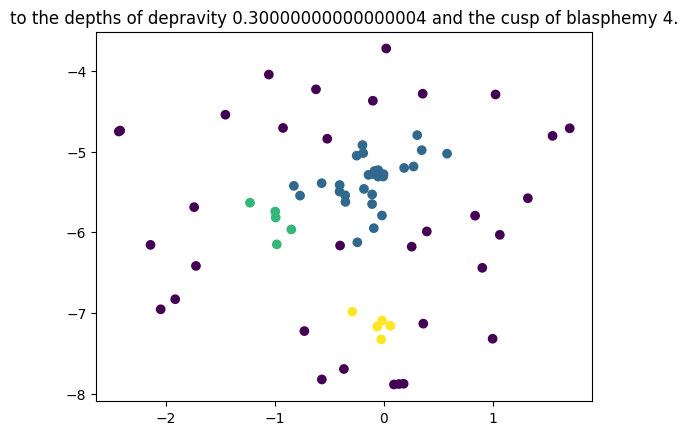

[ 0  0  0  0 -1  0 -1  0  1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  0 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  2 -1 -1  0 -1 -1  2 -1 -1  0  0 -1  2  2  2 -1
  0  0 -1  0  0  0  0  0  0 -1  0  0 -1 -1 -1  0  0  0  1  0  0  0  0  0]


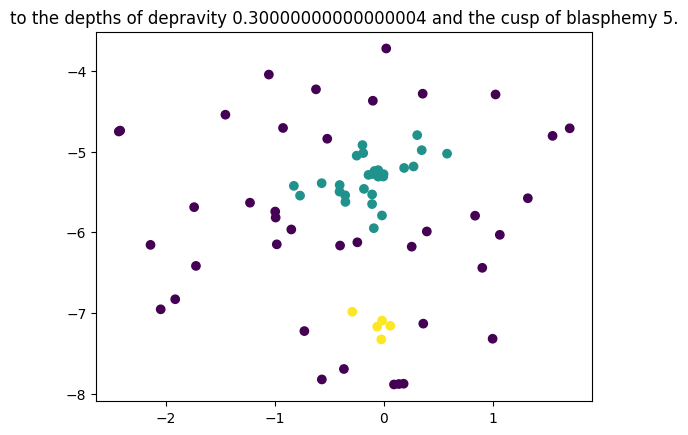

[ 0  0  0  0 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  1 -1 -1  0 -1 -1  1 -1 -1  0  0 -1  1  1  1 -1
  0 -1 -1  0  0  0  0  0  0 -1  0  0 -1 -1 -1  0  0  0 -1  0  0  0  0  0]


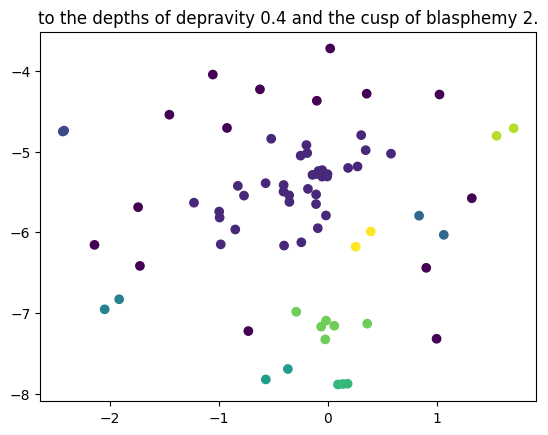

[ 0  0  0  0 -1  0 -1  0  0  0  1 -1 -1  2  0  1  0  0 -1  2 -1  0 -1 -1
 -1  0  3 -1 -1  4 -1  5  6  4  5  0  7  8  6  5  6  0  0 -1  6  6  6 -1
  0  0  8  0  0  0  0  0  0 -1  0  0  0  7  3  0  0  0  0  0  0  0  0  0]


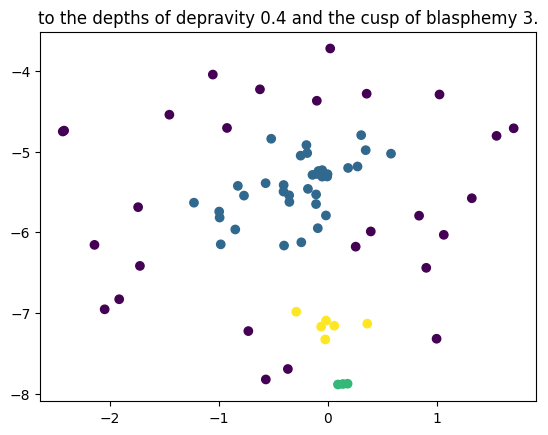

[ 0  0  0  0 -1  0 -1  0  0  0 -1 -1 -1 -1  0 -1  0  0 -1 -1 -1  0 -1 -1
 -1  0 -1 -1 -1 -1 -1  1  2 -1  1  0 -1 -1  2  1  2  0  0 -1  2  2  2 -1
  0  0 -1  0  0  0  0  0  0 -1  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0]


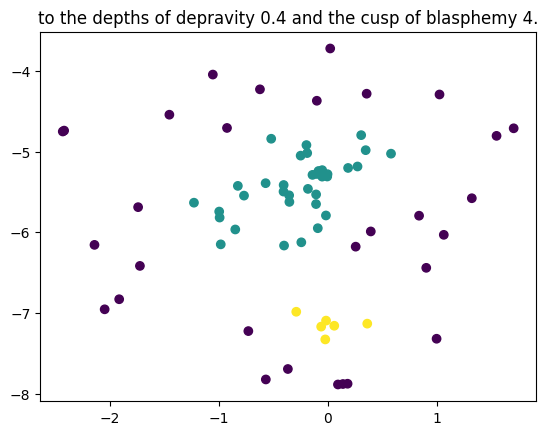

[ 0  0  0  0 -1  0 -1  0  0  0 -1 -1 -1 -1  0 -1  0  0 -1 -1 -1  0 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  1 -1 -1  0 -1 -1  1 -1  1  0  0 -1  1  1  1 -1
  0  0 -1  0  0  0  0  0  0 -1  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0]


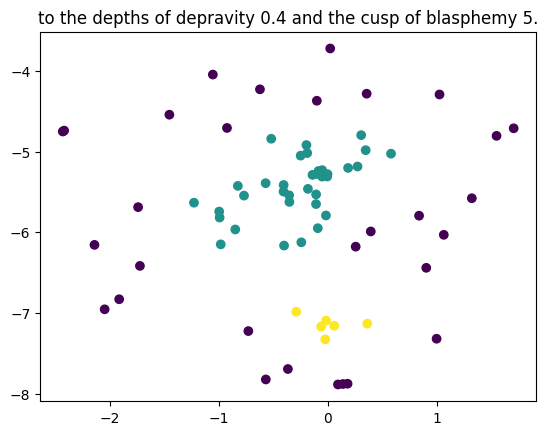

[ 0  0  0  0 -1  0 -1  0  0  0 -1 -1 -1 -1  0 -1  0  0 -1 -1 -1  0 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  1 -1 -1  0 -1 -1  1 -1  1  0  0 -1  1  1  1 -1
  0  0 -1  0  0  0  0  0  0 -1  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0]


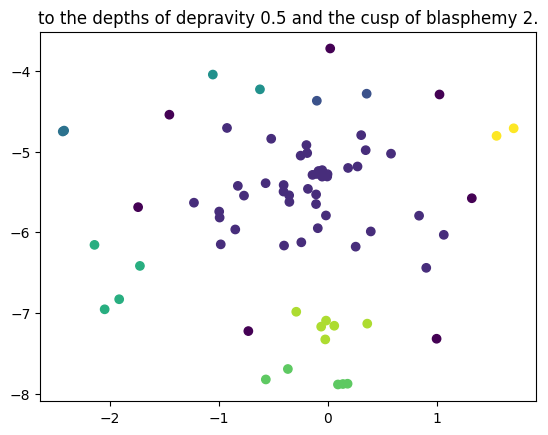

[ 0  0  0  0 -1  0  1  0  0  0  2 -1 -1  0  0  2  0  0  0  0 -1  0  1  3
  3  0  4  4  4  5 -1  5  6  5  5  0  7  0  6  5  6  0  0 -1  6  6  6  0
  0  0  0  0  0  0  0  0  0 -1  0  0  0  7  4  0  0  0  0  0  0  0  0  0]


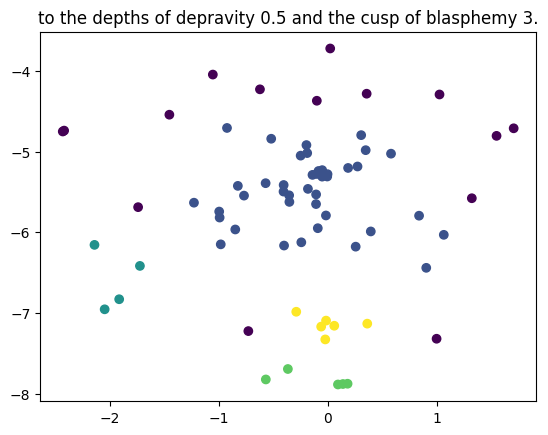

[ 0  0  0  0 -1  0 -1  0  0  0 -1 -1 -1  0  0 -1  0  0  0  0 -1  0 -1 -1
 -1  0  1  1  1  2 -1  2  3  2  2  0 -1  0  3  2  3  0  0 -1  3  3  3  0
  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  1  0  0  0  0  0  0  0  0  0]


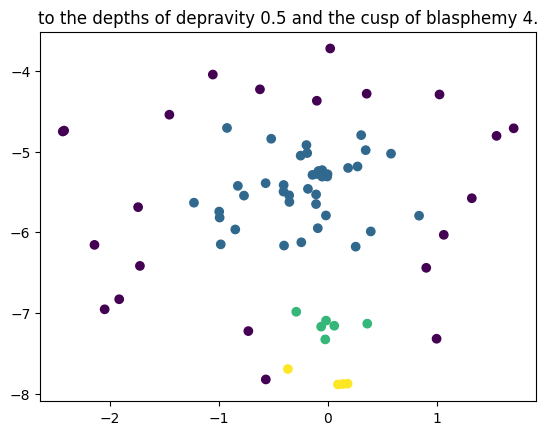

[ 0  0  0  0 -1  0 -1  0  0  0 -1 -1 -1  0  0 -1  0  0  0 -1 -1  0 -1 -1
 -1  0 -1 -1 -1 -1 -1  2  1  2  2  0 -1  0  1  2  1  0  0 -1  1  1  1 -1
  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0]


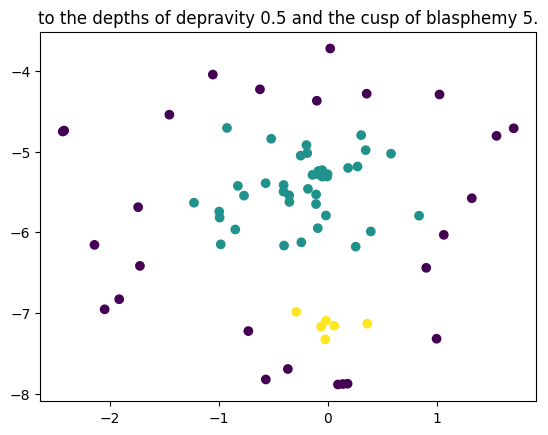

[ 0  0  0  0 -1  0 -1  0  0  0 -1 -1 -1  0  0 -1  0  0  0 -1 -1  0 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  1 -1 -1  0 -1  0  1 -1  1  0  0 -1  1  1  1 -1
  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0]


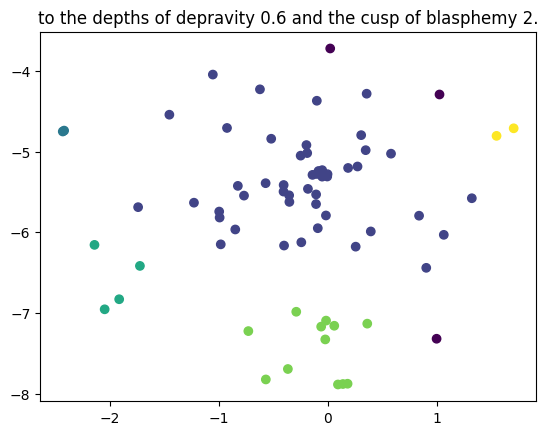

[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0 -1  0  0  0
  0  0  2  2  2  3  3  3  3  3  3  0  4  0  3  3  3  0  0 -1  3  3  3  0
  0  0  0  0  0  0  0  0  0 -1  0  0  0  4  2  0  0  0  0  0  0  0  0  0]


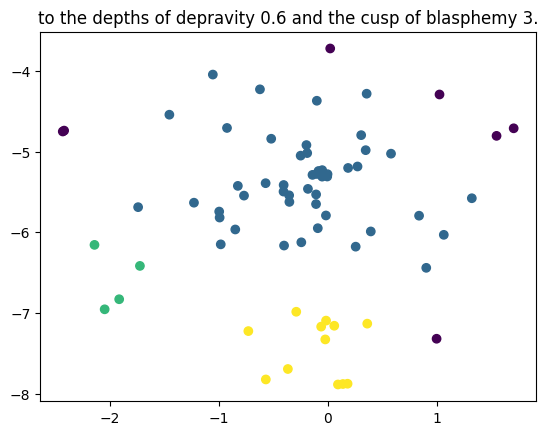

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0 -1  0  0  0
  0  0  1  1  1  2  2  2  2  2  2  0 -1  0  2  2  2  0  0 -1  2  2  2  0
  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  1  0  0  0  0  0  0  0  0  0]


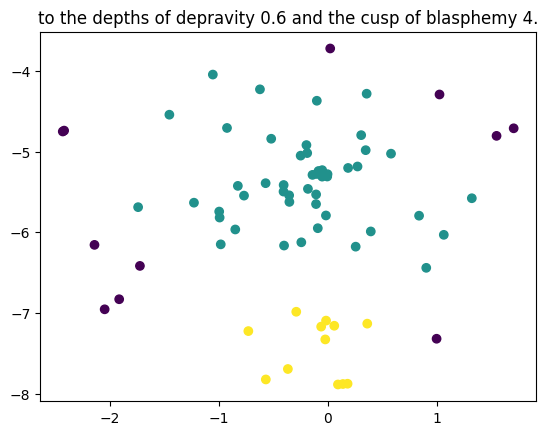

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0 -1  0  0  0
  0  0 -1 -1 -1  1  1  1  1  1  1  0 -1  0  1  1  1  0  0 -1  1  1  1  0
  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0]


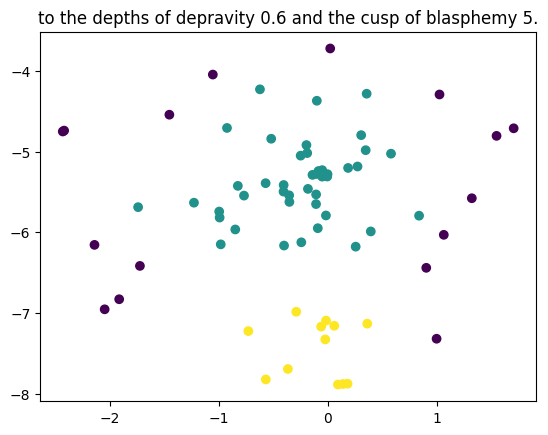

[ 0  0  0  0 -1  0  0  0  0  0 -1  0 -1  0  0 -1  0  0  0 -1 -1  0  0  0
 -1  0 -1 -1 -1  1  1  1  1  1  1  0 -1  0  1  1  1  0  0 -1  1  1  1 -1
  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0]


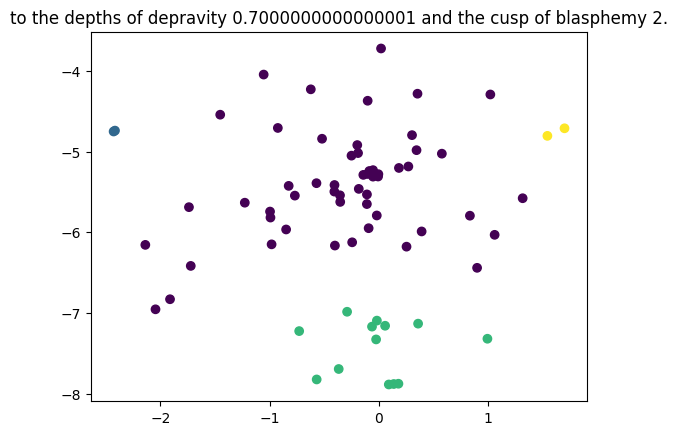

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 3
 0 2 2 2 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]


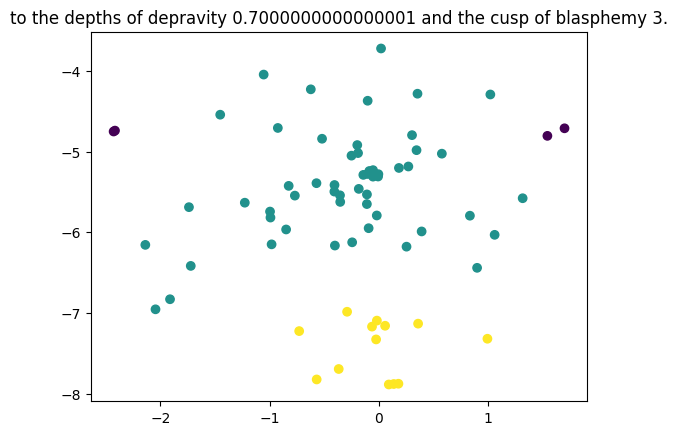

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  1  1  1  1  1  0 -1  0  1  1  1  0  0  1  1  1  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]


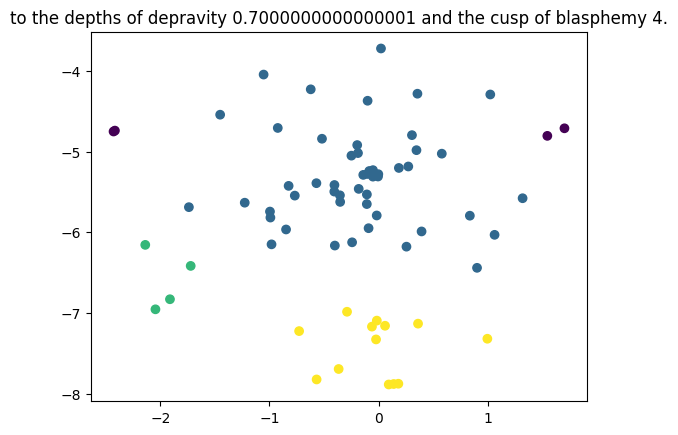

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  1  1  1  2  2  2  2  2  2  0 -1  0  2  2  2  0  0  2  2  2  2  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  1  0  0  0  0  0  0  0  0  0]


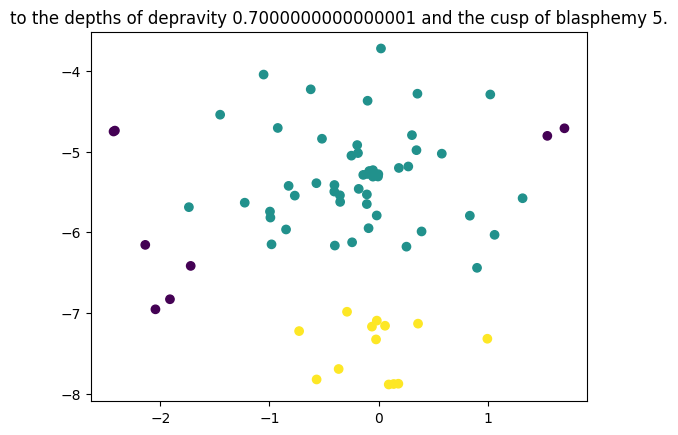

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0 -1 -1 -1  1  1  1  1  1  1  0 -1  0  1  1  1  0  0  1  1  1  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0]


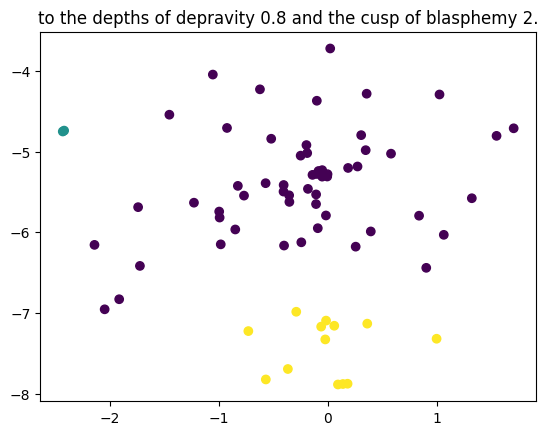

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0
 0 2 2 2 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


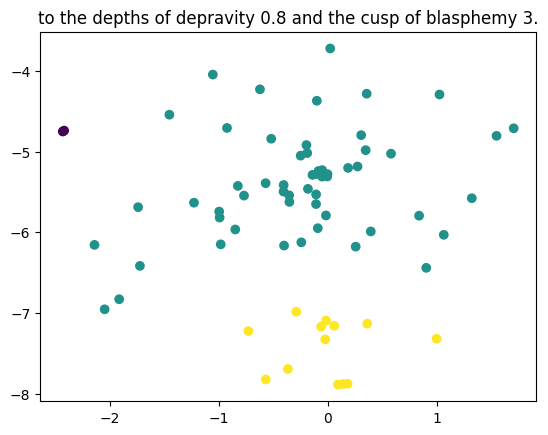

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  1  1  1  1  1  0  0  0  1  1  1  0  0  1  1  1  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


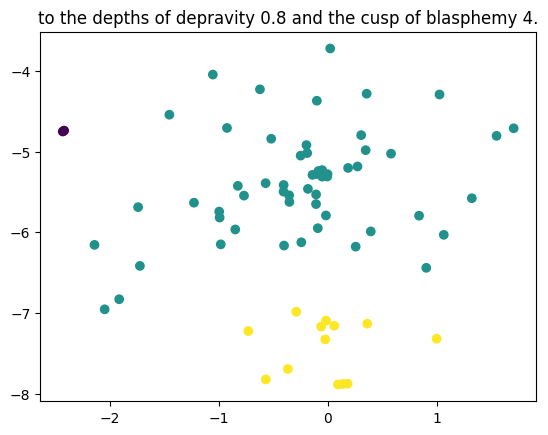

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  1  1  1  1  1  0  0  0  1  1  1  0  0  1  1  1  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


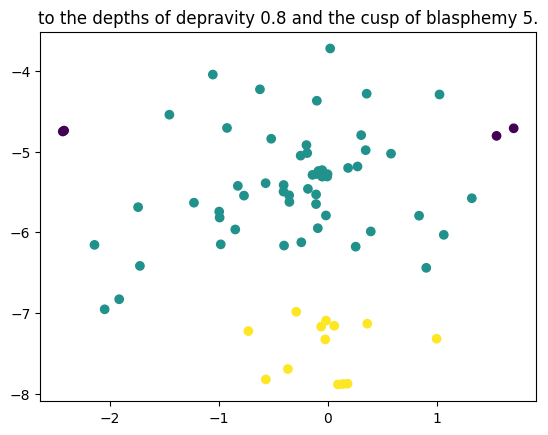

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  1  1  1  1  1  0 -1  0  1  1  1  0  0  1  1  1  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]


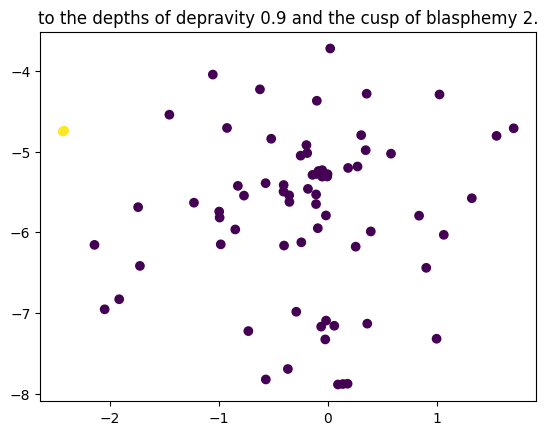

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


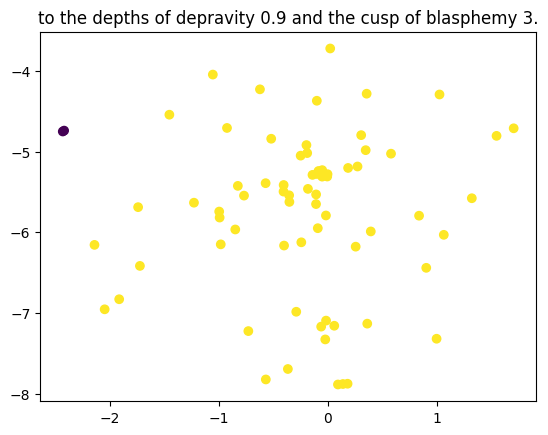

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


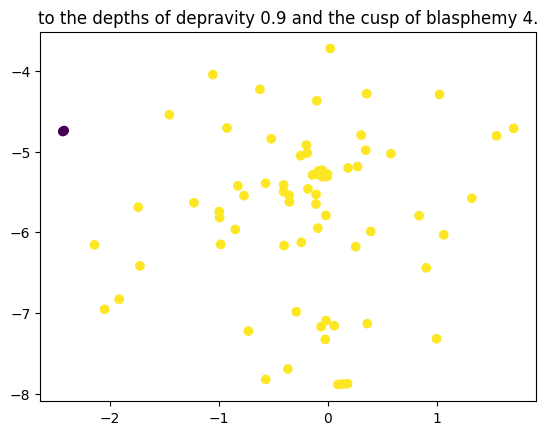

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


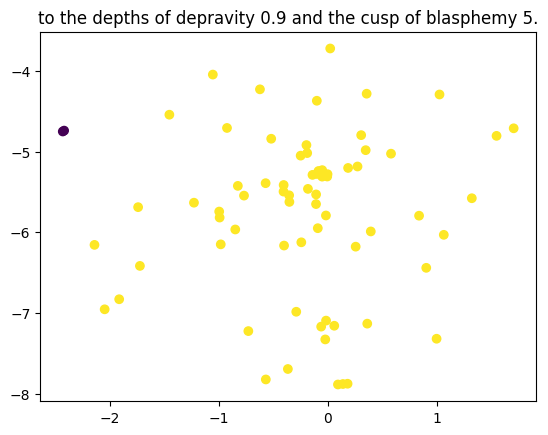

[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


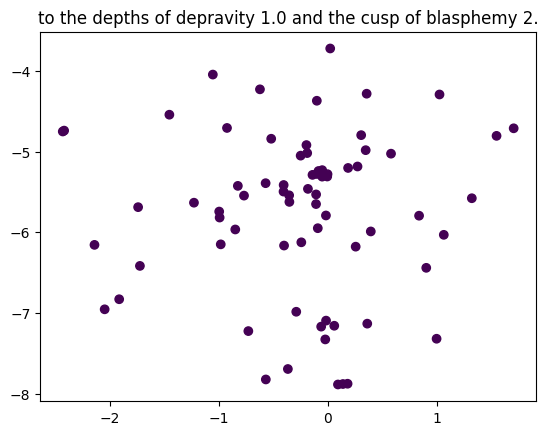

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


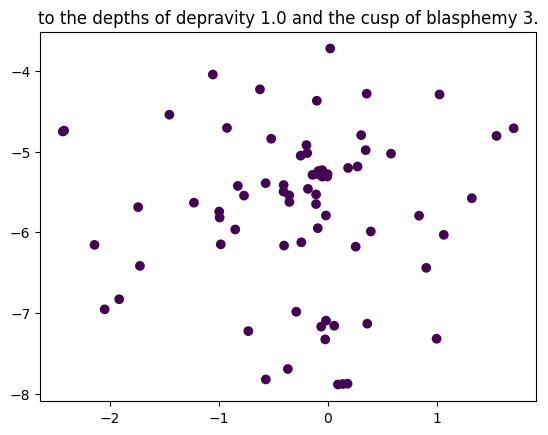

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


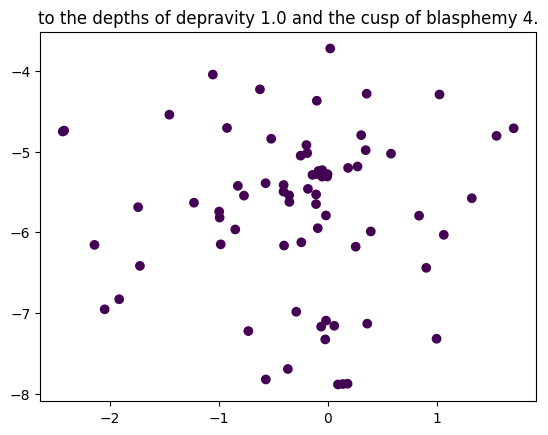

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


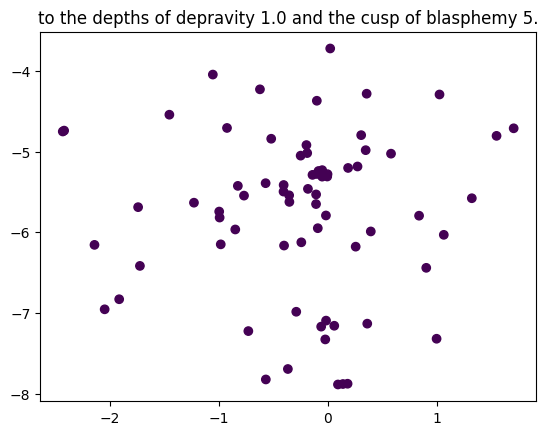

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


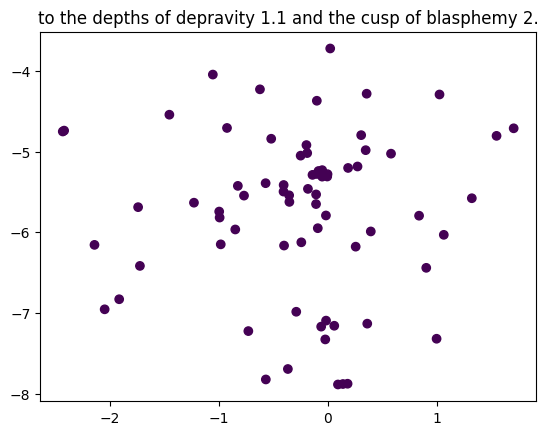

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


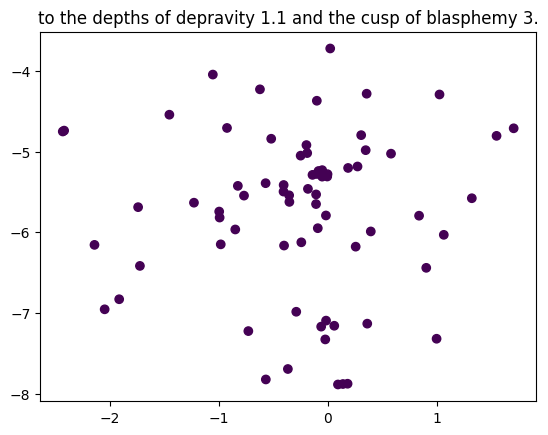

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


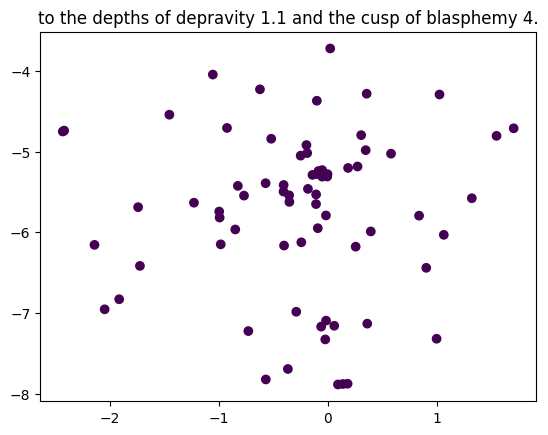

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


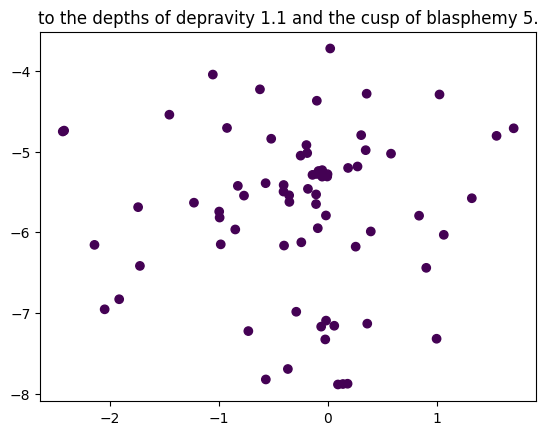

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


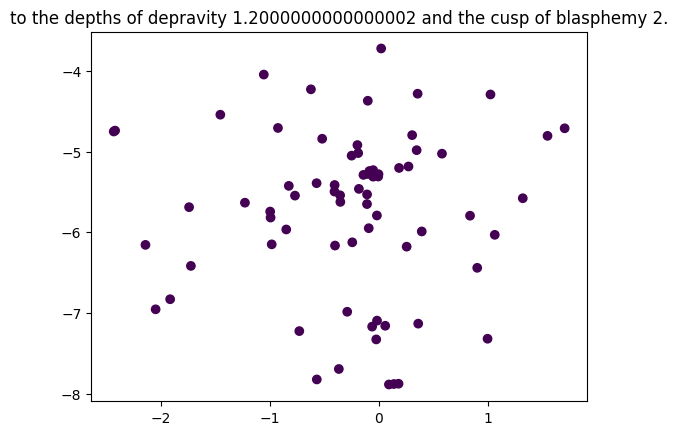

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


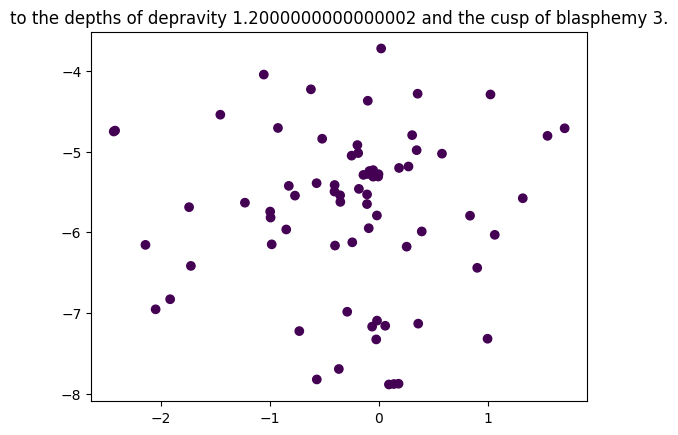

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


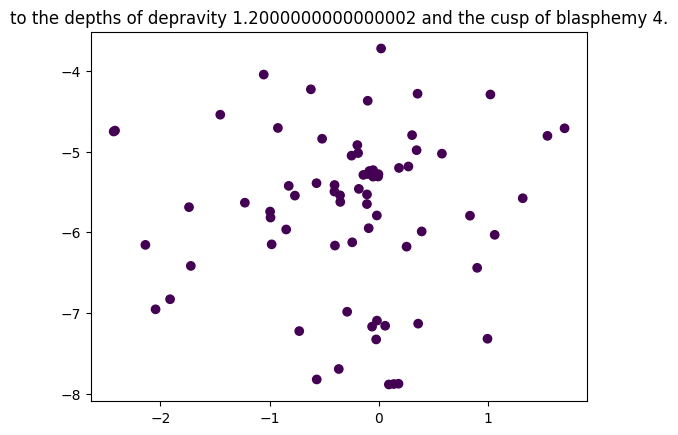

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


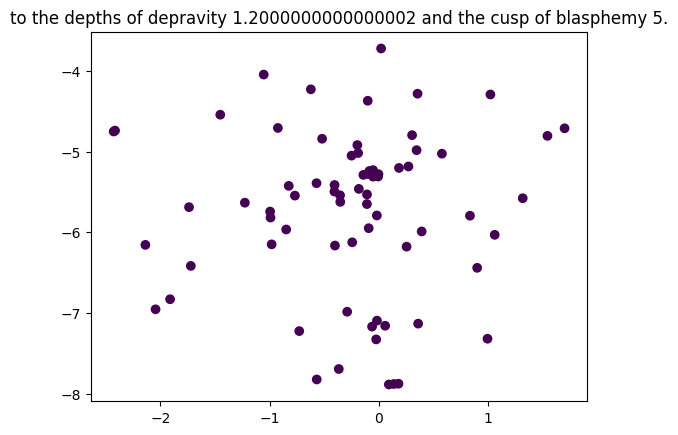

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


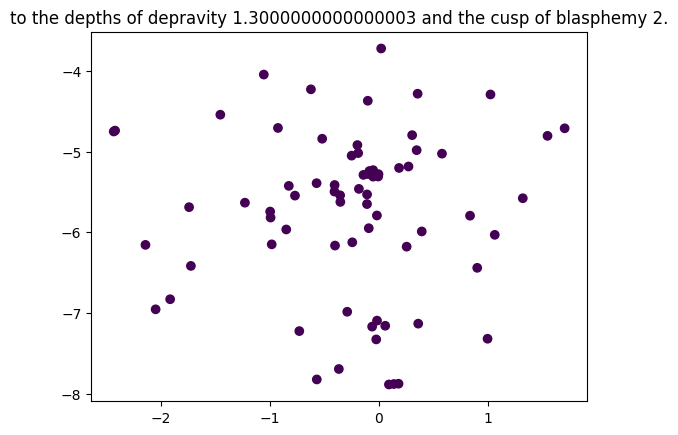

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


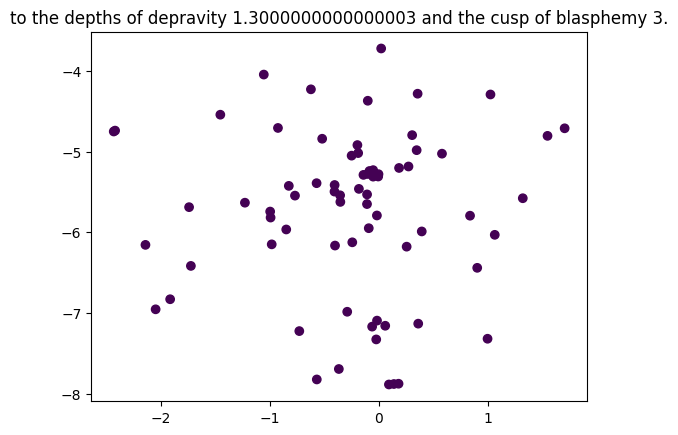

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


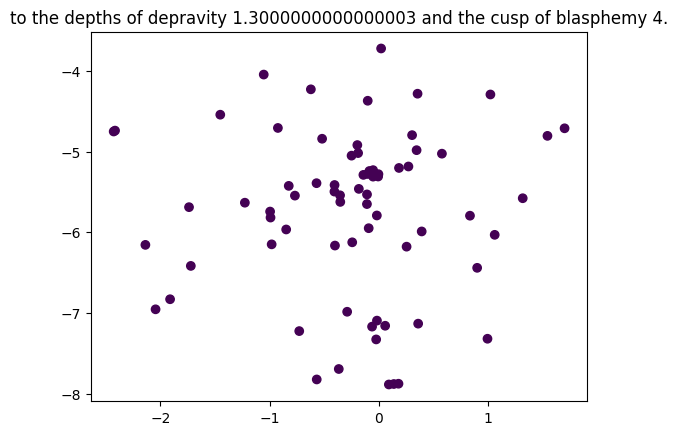

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


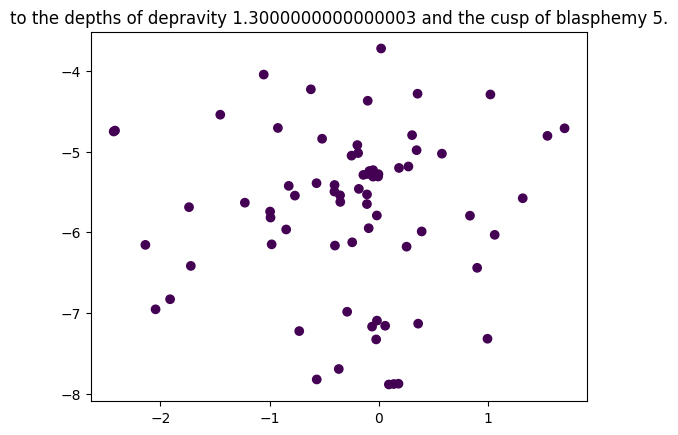

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


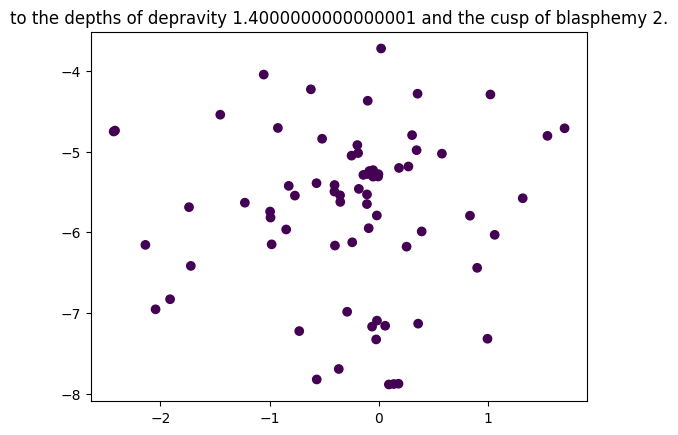

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


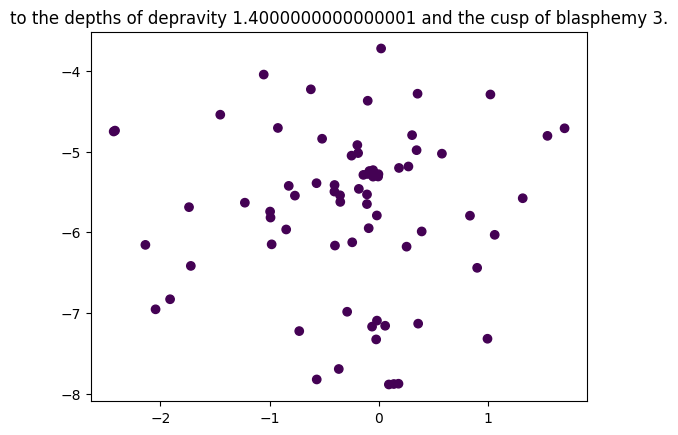

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


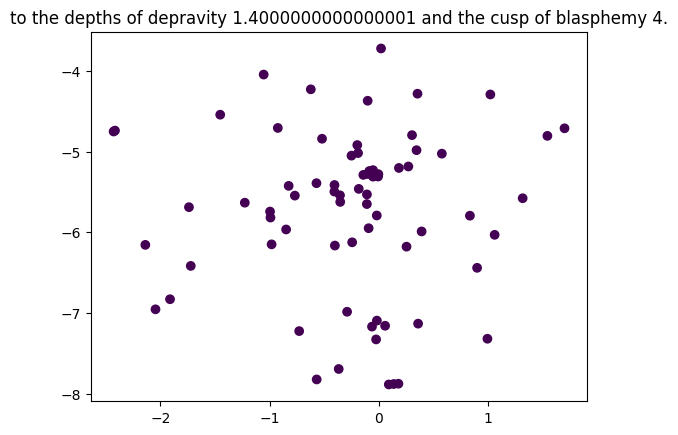

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


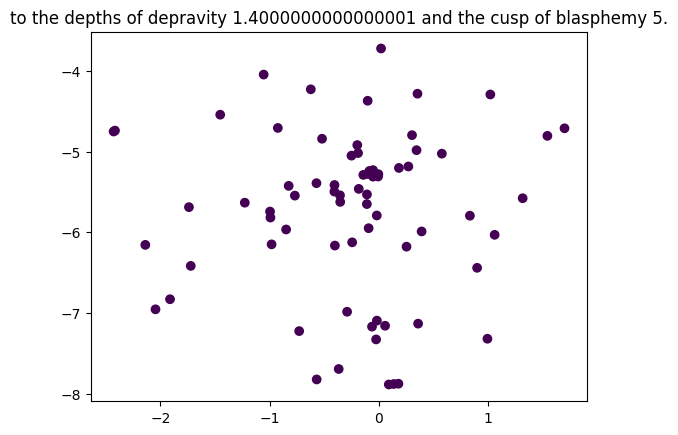

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


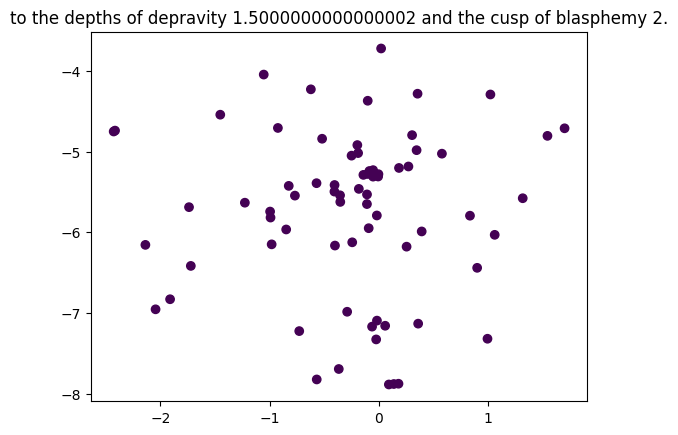

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


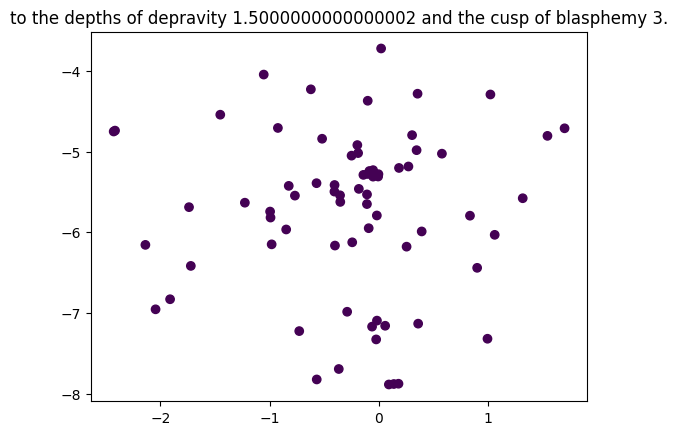

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


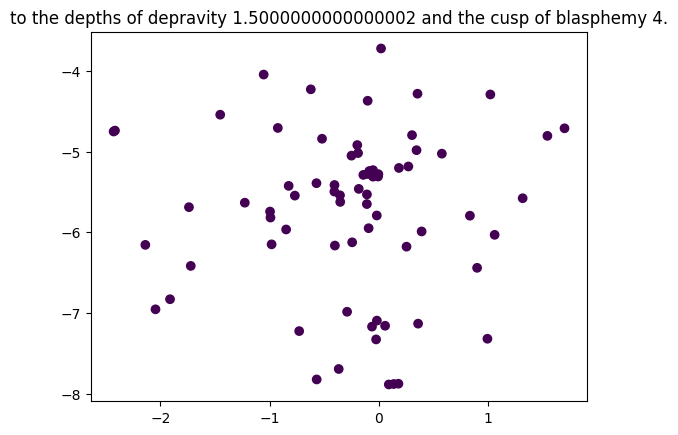

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


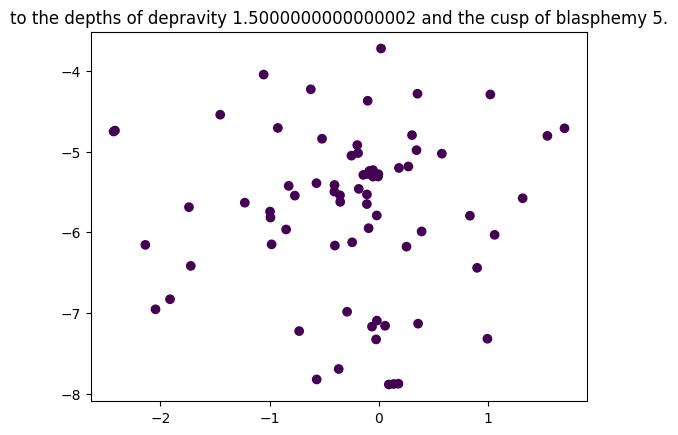

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


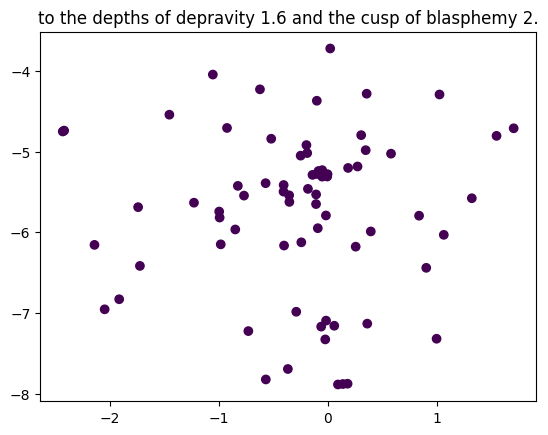

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


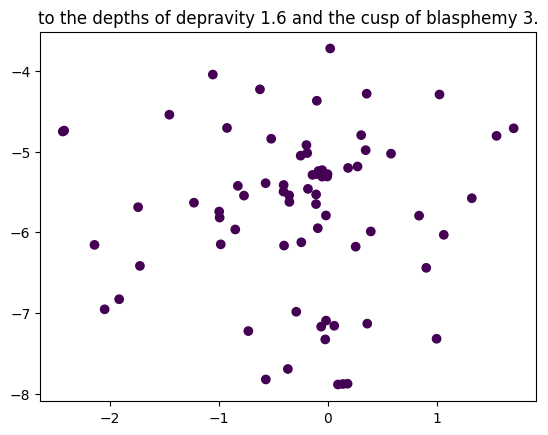

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


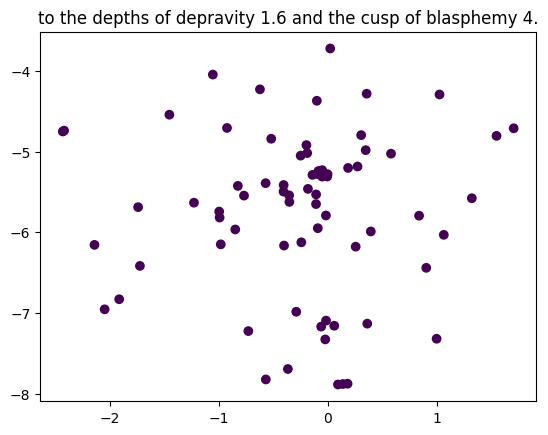

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


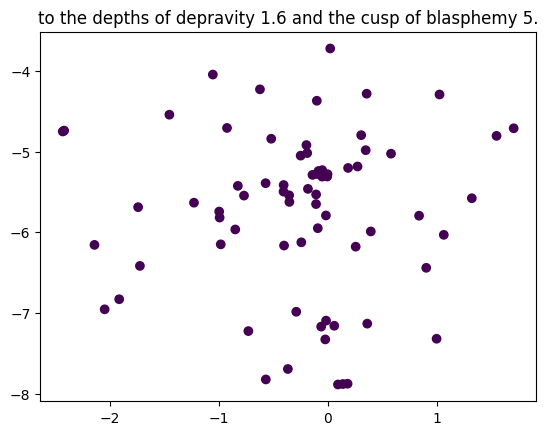

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


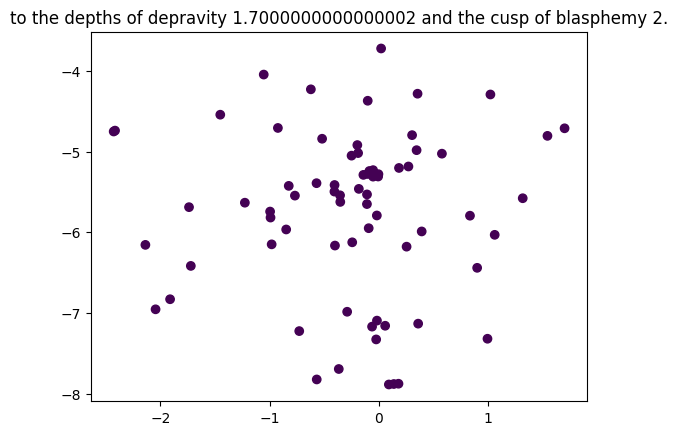

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


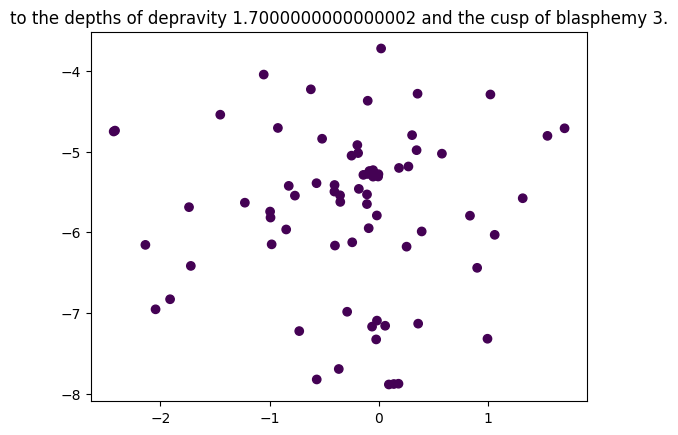

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


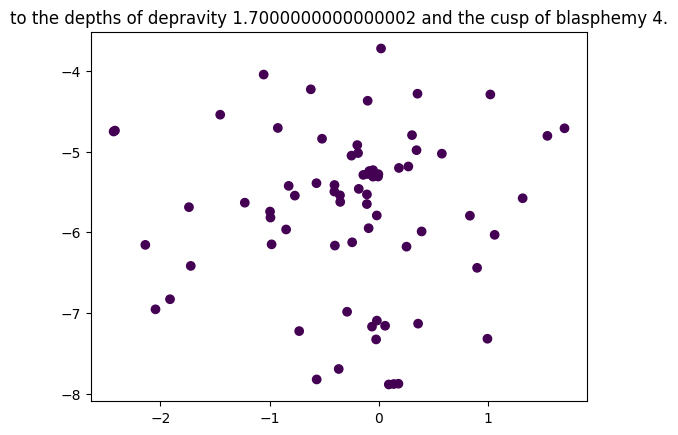

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


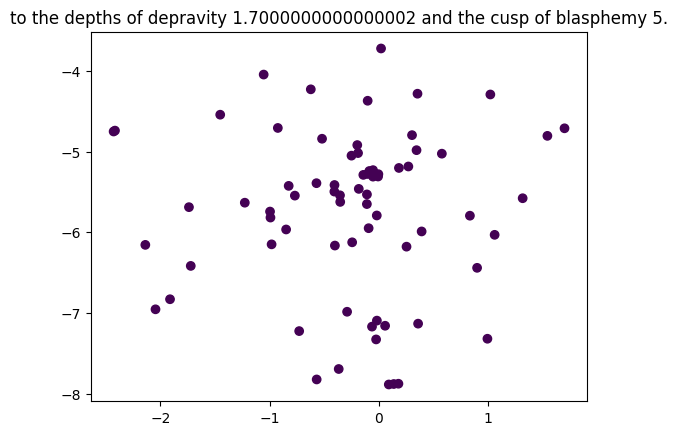

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


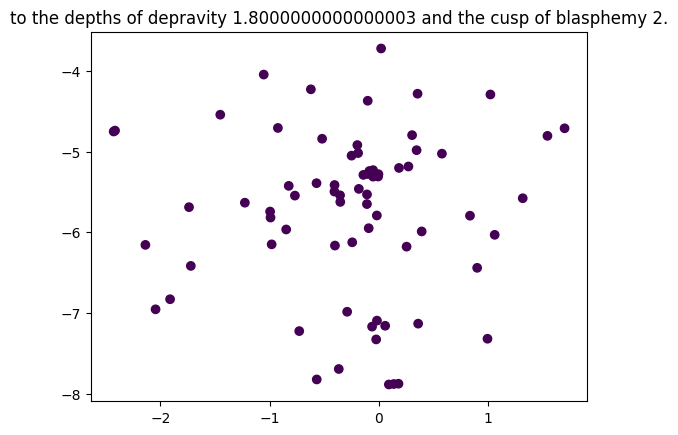

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


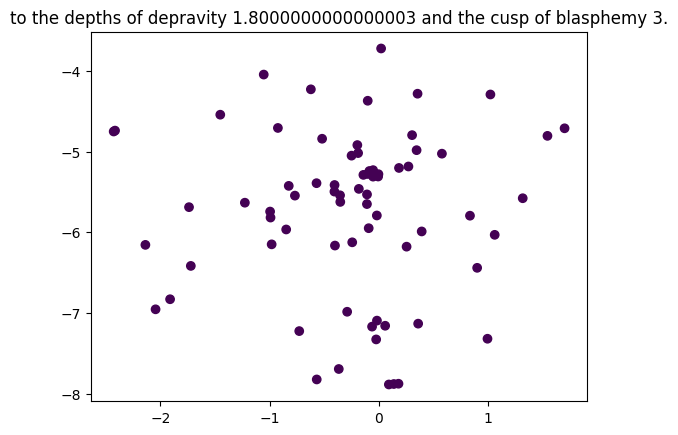

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


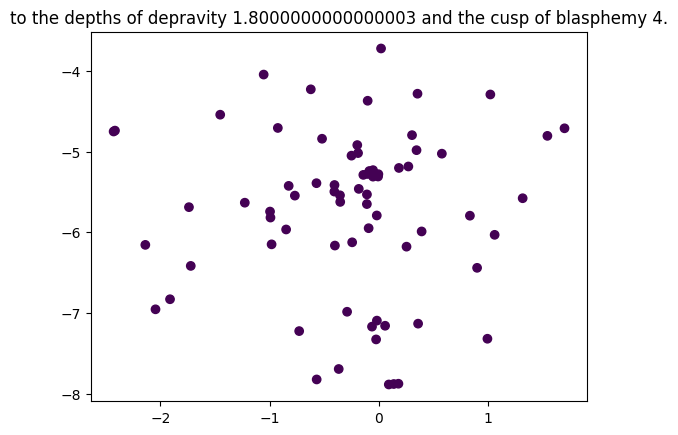

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


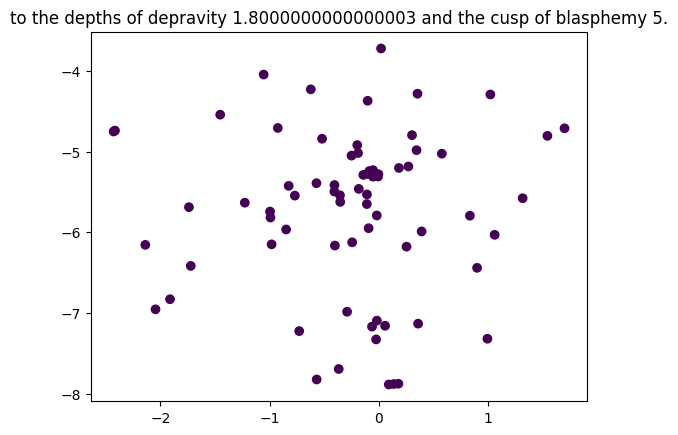

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


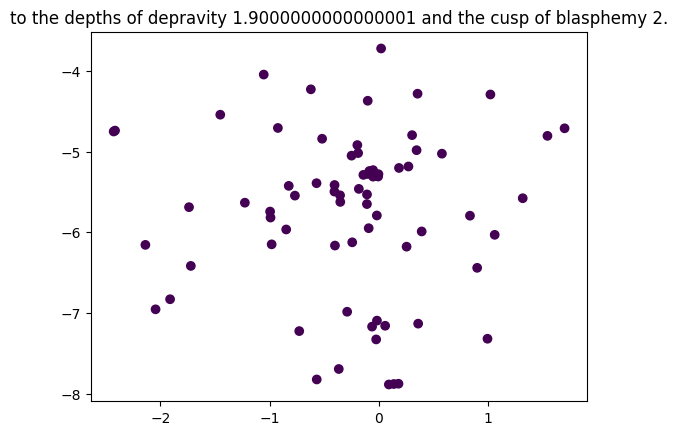

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


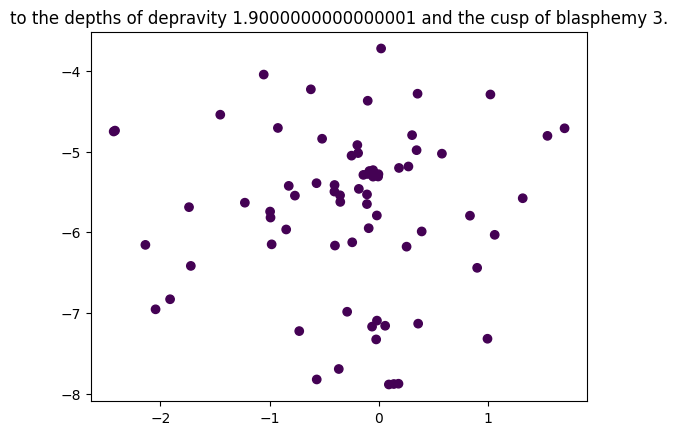

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


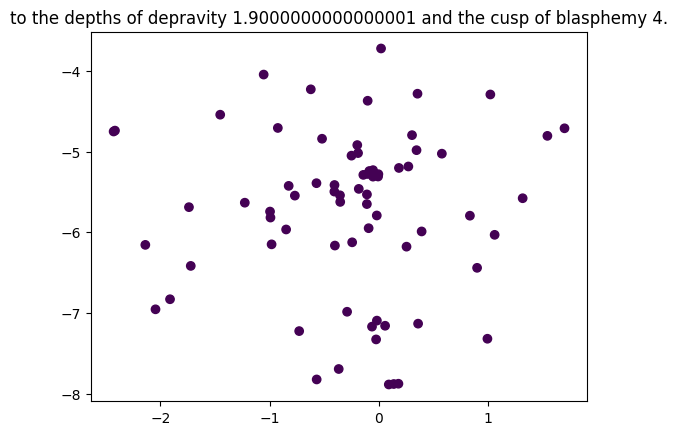

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


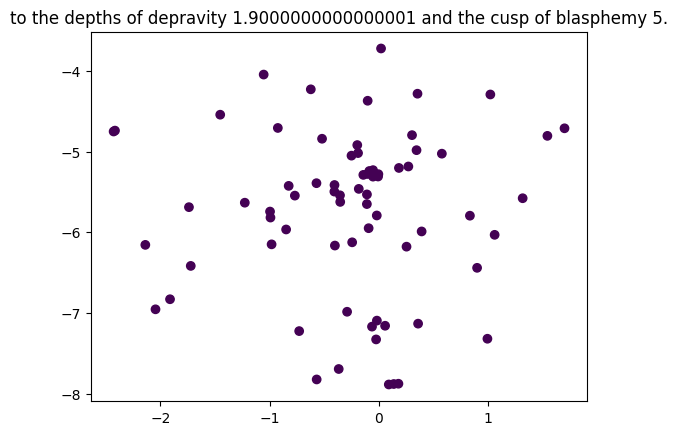

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [26]:
float_range = np.arange(start=0.1, stop=2, step=0.1, dtype=float)
for epsilon in float_range:
    for minsamp in range(2, 6):
        dbscan_draw(tsne_values, epsilon, minsamp)

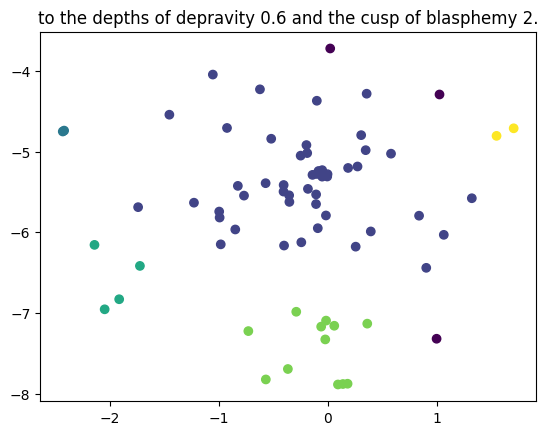

[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0 -1  0  0  0
  0  0  2  2  2  3  3  3  3  3  3  0  4  0  3  3  3  0  0 -1  3  3  3  0
  0  0  0  0  0  0  0  0  0 -1  0  0  0  4  2  0  0  0  0  0  0  0  0  0]


In [27]:
groups = dbscan_draw(tsne_values, 0.6, 2)



In [34]:
for i in range(len(groups)):
    if groups[i] == -1:
        print(df["Answer"][i])

The creator would be a dictator of value then, and the only entity from whom value is derived.
If I choose to be in hell.
Prochoice. Unless the baby is normal.


In [35]:
# group by event
eventList = df["Event"].unique()

df_by_event_list = []
 
for event in eventList:
    df_by_event_list.append(df[df["Event"] == event])


something wrong here idk why?!?!

In [36]:
plot_documents(df_by_event_list[0])

ValueError: perplexity must be less than n_samples